# Load Preprocessed Data

In [10]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/dimasmhrdka/data-csv/main/cleaned-data-kelas.csv', index_col=0)
df.head()

,NIM,Nama,Judul,Abstrak,Kelas,judul_tokens,abstrak_tokens
0,40411100468,A.Ubaidillah S.Kom,perancangan dan implementasi sistem database t...,sistem informasi akademik siakad merupakan sis...,RPL,rancang implementasi sistem database distribus...,sistem informasi akademik siakad sistem inform...
1,40411100476,"M. Basith Ardianto,",aplikasi kontrol dan monitoring jaringan kompu...,berjalannya koneksi jaringan komputer dengan l...,RPL,aplikasi kontrol monitoring jaring komputer ba...,jalan koneksi jaring komputer lancar ganggu ha...
2,70411100070,Heri Supriyanto,sistem pendukung keputusan optimasi penjadwala...,penjadwalan kuliah di perguruan tinggi merupak...,Komputasi,sistem dukung putus optimasi jadwal matakuliah...,jadwal kuliah guru kompleks masalah variabel t...
3,80411100115,Septian Rahman Hakim,sistem augmented reality animasi benda bergera...,seiring perkembangan teknologi yang ada diduni...,Komputasi,sistem augmented reality animasi benda gerak f...,iring kembang teknologi dunia muncul teknologi...
4,70411100007,Adi Chandra Laksono,gerak pekerja pada game real time strategy men...,gerak pekerja ada pada game yang memiliki genr...,RPL,gerak kerja game real time strategy finite sta...,gerak kerja game milik genre rts real time str...


# Split Data

In [11]:
from sklearn.model_selection import train_test_split

X = df['abstrak_tokens']
y = df['Kelas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Extraction: TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf.shape

(554, 4881)

In [13]:
terms = vectorizer.get_feature_names_out()

sums = X_train_tfidf.sum(axis=0)

data = []
for col, term in enumerate (terms):
    data.append((term, sums[0,col]))
    
ranking = pd.DataFrame(data, columns=['term', 'rank'])
print(ranking.sort_values('rank', ascending=False))

        term       rank
4077  sistem  23.040459
701    citra  21.107039
854     data  20.648087
2709  metode  20.359528
1550   hasil  19.415775
...      ...        ...
3608   ratus   0.050905
690    china   0.050905
2578    mbps   0.045443
1647    idle   0.045443
3544     qos   0.045443

[4881 rows x 2 columns]



# Oversampling: SMOTE

In [14]:
y_train.value_counts()

Komputasi    301
RPL          178
NLP           75
Name: Kelas, dtype: int64

In [15]:
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_tfidf, y_train)

y_train_resampled.value_counts()

Komputasi    301
RPL          301
NLP          301
Name: Kelas, dtype: int64

# Training Model

## GridSearchCV

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'criterion':['gini','entropy', 'log_loss'],'max_depth':[10, 20, 30, None]}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc_ovr', cv=10, verbose=3)

# fitting the model for grid search
grid.fit(X_train_resampled, y_train_resampled)


Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END .....criterion=gini, max_depth=10;, score=0.764 total time=   0.1s
[CV 2/10] END .....criterion=gini, max_depth=10;, score=0.860 total time=   0.1s
[CV 3/10] END .....criterion=gini, max_depth=10;, score=0.797 total time=   0.1s
[CV 4/10] END .....criterion=gini, max_depth=10;, score=0.821 total time=   0.1s
[CV 5/10] END .....criterion=gini, max_depth=10;, score=0.855 total time=   0.1s
[CV 6/10] END .....criterion=gini, max_depth=10;, score=0.819 total time=   0.1s
[CV 7/10] END .....criterion=gini, max_depth=10;, score=0.913 total time=   0.1s
[CV 8/10] END .....criterion=gini, max_depth=10;, score=0.870 total time=   0.1s
[CV 9/10] END .....criterion=gini, max_depth=10;, score=0.868 total time=   0.1s
[CV 10/10] END ....criterion=gini, max_depth=10;, score=0.884 total time=   0.1s
[CV 1/10] END .....criterion=gini, max_depth=20;, score=0.761 total time=   0.2s
[CV 2/10] END .....criterion=gini, max_depth=2

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30, None]},
             scoring='roc_auc_ovr', verbose=3)

In [17]:
# Tabel hasil GridSearchCV
results_df = pd.DataFrame(grid.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124175,0.006890,0.005966,0.000303,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.763924,0.859516,0.797033,0.821204,0.854537,0.819074,0.912778,0.870093,0.867593,0.884167,0.844992,0.042050,2
1,0.116689,0.020978,0.004646,0.001209,gini,20,"{'criterion': 'gini', 'max_depth': 20}",0.760717,0.752302,0.743917,0.791667,0.783333,0.866667,0.879167,0.858333,0.850000,0.900000,0.818610,0.055192,6
2,0.106827,0.003705,0.003975,0.000186,gini,30,"{'criterion': 'gini', 'max_depth': 30}",0.760538,0.793653,0.736085,0.775000,0.833333,0.850000,0.916667,0.883333,0.866667,0.883333,0.829861,0.057399,4
3,0.106890,0.005715,0.003878,0.000114,gini,None,"{'criterion': 'gini', 'max_depth': None}",0.752430,0.769193,0.760635,0.808333,0.808333,0.841667,0.883333,0.875000,0.866667,0.900000,0.826559,0.051572,5
4,0.108069,0.005613,0.004222,0.000417,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.762978,0.749840,0.862959,0.781481,0.836296,0.865926,0.937037,0.839444,0.882222,0.919907,0.843809,0.060115,3
5,0.126453,0.004457,0.004186,0.000459,entropy,20,"{'criterion': 'entropy', 'max_depth': 20}",0.727879,0.727074,0.793786,0.766667,0.766667,0.825000,0.883333,0.816667,0.866667,0.883333,0.805707,0.056295,11
6,0.124759,0.003501,0.003976,0.000178,entropy,30,"{'criterion': 'entropy', 'max_depth': 30}",0.719771,0.710678,0.826849,0.775000,0.766667,0.825000,0.891667,0.825000,0.866667,0.891667,0.809896,0.061962,8
7,0.127954,0.009693,0.004210,0.000842,entropy,None,"{'criterion': 'entropy', 'max_depth': None}",0.744546,0.710453,0.810407,0.758333,0.750000,0.825000,0.875000,0.825000,0.850000,0.916667,0.806541,0.061641,10
8,0.105928,0.003599,0.004647,0.001241,log_loss,10,"{'criterion': 'log_loss', 'max_depth': 10}",0.774205,0.759949,0.858770,0.792593,0.836296,0.847130,0.936759,0.831574,0.897222,0.920000,0.845450,0.056756,1
9,0.155304,0.032986,0.004956,0.001006,log_loss,20,"{'criterion': 'log_loss', 'max_depth': 20}",0.727879,0.735407,0.818650,0.783333,0.783333,0.833333,0.883333,0.791667,0.858333,0.883333,0.809860,0.052704,9


In [18]:
# Peringkat Score Parameter hasil GridSearchCV
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("criterion")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
criterion,,,,
log_loss_10,"{'criterion': 'log_loss', 'max_depth': 10}",1,0.845450,0.056756
gini_10,"{'criterion': 'gini', 'max_depth': 10}",2,0.844992,0.042050
entropy_10,"{'criterion': 'entropy', 'max_depth': 10}",3,0.843809,0.060115
gini_30,"{'criterion': 'gini', 'max_depth': 30}",4,0.829861,0.057399
gini_None,"{'criterion': 'gini', 'max_depth': None}",5,0.826559,0.051572
gini_20,"{'criterion': 'gini', 'max_depth': 20}",6,0.818610,0.055192
log_loss_None,"{'criterion': 'log_loss', 'max_depth': None}",7,0.813982,0.055931
entropy_30,"{'criterion': 'entropy', 'max_depth': 30}",8,0.809896,0.061962
log_loss_20,"{'criterion': 'log_loss', 'max_depth': 20}",9,0.809860,0.052704


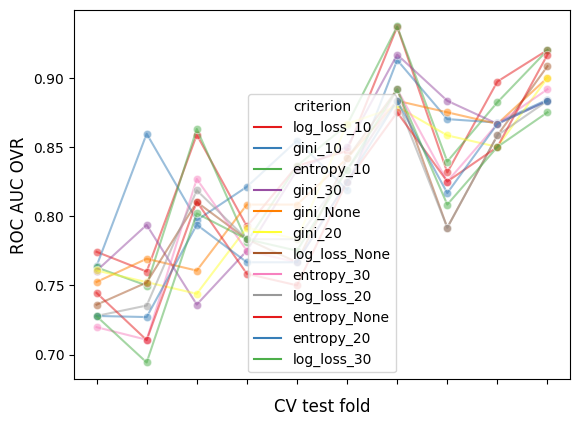

Correlation of models:
 criterion      log_loss_10   gini_10  entropy_10   gini_30  gini_None  \
criterion                                                               
log_loss_10       1.000000  0.626555    0.987253  0.698757   0.769627   
gini_10           0.626555  1.000000    0.599982  0.851851   0.786399   
entropy_10        0.987253  0.599982    1.000000  0.706878   0.772137   
gini_30           0.698757  0.851851    0.706878  1.000000   0.931051   
gini_None         0.769627  0.786399    0.772137  0.931051   1.000000   
gini_20           0.743749  0.662298    0.764311  0.903737   0.965372   
log_loss_None     0.933568  0.619569    0.926570  0.695026   0.813528   
entropy_30        0.957933  0.594379    0.959173  0.694118   0.831280   
log_loss_20       0.968031  0.605097    0.964098  0.677934   0.799126   
entropy_None      0.921403  0.539103    0.925736  0.696756   0.838405   
entropy_20        0.952775  0.665377    0.946857  0.788363   0.890892   
log_loss_30       0.949533 

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose(),
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("ROC AUC OVR", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

In [20]:
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)
model = clf.fit(X_train_resampled,y_train_resampled)

[Text(0.5754032258064516, 0.9545454545454546, 'x[107] <= 0.0\ngini = 0.667\nsamples = 903\nvalue = [301, 301, 301]'),
 Text(0.4342741935483871, 0.8636363636363636, 'x[3409] <= 0.0\ngini = 0.606\nsamples = 499\nvalue = [144, 93, 262]'),
 Text(0.3556451612903226, 0.7727272727272727, 'x[390] <= 0.003\ngini = 0.569\nsamples = 463\nvalue = [142, 59, 262]'),
 Text(0.23709677419354838, 0.6818181818181818, 'x[2709] <= 0.011\ngini = 0.612\nsamples = 299\nvalue = [132, 43, 124]'),
 Text(0.15161290322580645, 0.5909090909090909, 'x[126] <= 0.018\ngini = 0.537\nsamples = 118\nvalue = [24, 20, 74]'),
 Text(0.12258064516129032, 0.5, 'x[167] <= 0.024\ngini = 0.438\nsamples = 101\nvalue = [16, 12, 73]'),
 Text(0.10967741935483871, 0.4090909090909091, 'x[1882] <= 0.025\ngini = 0.389\nsamples = 96\nvalue = [16, 7, 73]'),
 Text(0.0967741935483871, 0.3181818181818182, 'x[2827] <= 0.0\ngini = 0.348\nsamples = 92\nvalue = [12, 7, 73]'),
 Text(0.05161290322580645, 0.22727272727272727, 'x[3874] <= 0.029\ngini 

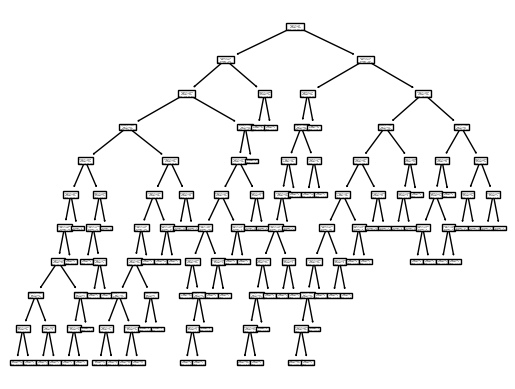

In [21]:
from sklearn import tree

tree.plot_tree(model) 

In [22]:
print('Decision Tree depth : ',model.get_depth())
print('Decision Tree n leaves : ',model.get_n_leaves())

Decision Tree depth :  10
Decision Tree n leaves :  70


# Evaluation

In [23]:
predictions = model.predict(X_test_tfidf)

In [24]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[78 10 25]
 [23 15 11]
 [19  4 53]]


In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_tfidf, y_test) 
plt.show()

ValueError: ignored

In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Print the overall metrics
print('Accuracy score : ', accuracy_score(y_test, predictions))
print('Precision score : ', precision_score(y_test, predictions, average='weighted'))
print('Recall score : ', recall_score(y_test, predictions, average='weighted'))
print('F1 score : ', f1_score(y_test, predictions, average='weighted'))

# Export Model

In [ ]:
from joblib import dump

dump(model, filename="model/dtc-model-abstrak.joblib")
dump(vectorizer, filename="model/vectorizer_model_abstrak.joblib")

# Demo

In [ ]:
title_input = input("Masukkan Abstrak Skripsi:\n")

'''
catatan input:
sisinta um adalah sistem informasi berbasis website bertujuan untuk menampilkan data yang berkaitan dengan skripsi dan tugas akhir pada jurusan teknik elektro fakultas teknik universitas negeri malang. penggunaan sistem informasi sisinta memiliki potensi jika dikembangkan dengan mengklasifikasikan judul dan abstrak berdasarkan tema penelitiannya. tujuan penelitian ini adalah untuk menerapkan dan menguji performa algoritma decision tree classifier dalam mengklasifikasi judul skripsi dan tugas akhir, berdasarkan tema penelitian dalam kbk di jurusan teknik elektro ft um. decision tree classifier adalah algoritma supervised learning non-parametrik, yang digunakan untuk klasifikasi dan regresi. decision tree memiliki hierarki, struktur pohon, yang terdiri dari root node, branches, internal nodes dan leaf nodes. dengan menggunakan metode decision tree classifier dalam implementasinya diharapkan dapat memprediksi jenis kelompok bidang keahlian yang sesuai. data yang digunakan dalam penelitian sistem klasifikasi ini didapatkan dari database sisinta te-um berupa judul, abstrak, dan kbk yang terkait dengan tema penelitian pada skripsi dan tugas akhir tersebut.
'''

hasil = clf.predict_proba(vectorizer.transform([title_input]))

print(f"Abstrak Skripsi: {title_input}")

list1 = hasil.tolist()
cls = clf.classes_
list2 = cls.tolist()

d = {"Kelompok Bidang Keahlian":list2,"Probability":list1[0]}
df_proba = pd.DataFrame(d)

print(df_proba.sort_values("Probability", ascending=False))